In [1]:
import numpy as np
from math import floor, log10
import matplotlib.pyplot as plt
from scipy import special, optimize
from scipy.integrate import solve_bvp, quad
import locale
from statistics import median

# Set to German locale to get comma decimal separater
locale.setlocale(locale.LC_NUMERIC, "ru_RU")
plt.rcParams.update({"font.size": 13})
params = {"text.latex.preamble": r"\usepackage{icomma}"}
plt.rcParams["axes.formatter.use_locale"] = True
plt.rcParams.update(params)

props = dict(boxstyle="square", facecolor="white")
props_note = dict(boxstyle="ellipse", facecolor="white")

eV_to_J = 1.6e-19
eV_to_K = 11604
J_to_eV = 6.242e18
eV_to_erg = 1.602e-12
erg_to_eV = 6.242e11
K_to_erg = 1.381e-16
erg_to_K = 7.243e15
Cl_to_SGS = 3.0e9

mi = 1.67e-24  # ion(proton) mass
me = 9.11e-28  # electron mass
e = 1.6e-19 * Cl_to_SGS  # electric charge of electron
a = 120.4 / K_to_erg**2 * Cl_to_SGS  # Richardson's constant
sigma = 5.67e-5 # Stefan-Boltzmann constant
phiout = 4.54 * eV_to_erg  # Pa6oma

nse = 1.0e13  # plasma component density
Te = 30.0 * eV_to_erg  # electron temperature
deltae = 0  # SEE coefficient
cs = np.sqrt(Te / mi)  # Bohm's criterion velocity
# vth = np.sqrt(8 * Te / (np.pi * me))  # Thermal electron velocity

#at T = 3000
rho = 18.22
Cp = 217.8*1.0e7/1.0e3
kappa = 21.2*1.0e6*1.0e4



r_debye = np.sqrt(Te / (4 * np.pi * nse * e**2))

n_coefs = {
    "T": Te,
    "n": nse,
    "v": cs,
    "j": e * nse * cs,
    "q": Te * nse * cs,
    "l": r_debye,
    "t": 2*np.pi/np.sqrt(4*np.pi*nse*e**2/me)
}


def TK(T):  # dimensionless form temperature to [K]
    return T * Te * erg_to_K


def TD(T):  # [K] temperature to dimensionless form
    return T / Te * K_to_erg

# Classic

In [2]:
def nte_w_func(derw, Tw):
    dA = -np.sign(derw) * np.sqrt(abs(derw)) * np.sqrt(e * Te / r_debye) * 300
    # print(dA * Te * erg_to_eV, phiout * erg_to_eV)
    return (
        a
        * (Tw * Te) ** 2.0
        * np.exp(-(phiout / Te + dA) / Tw)
        / (0.25 * e * nse * np.sqrt(Tw * Te * 8.0 / np.pi / me))
    )


def upsilon_0_func(phi_se):
    return np.sqrt(-2.0 * phi_se)


########################################################


def j_wall(y, args):
    derw, n_e, V_f, phi_se = y
    Tw, nte_w, nse, upsilon_0 = args
    return V_f - np.log(
        4 * upsilon_0 / (n_e * np.sqrt(8 * mi / (np.pi * me)))
        + nte_w / n_e * np.sqrt(Tw)
    )


def Bohm_criterion(y, args):
    derw, n_e, V_f, phi_se = y
    Tw, nte_w, nse, upsilon_0 = args
    return phi_se + 0.5 * Tw / (
        n_e * Tw
        + nte_w
        * (
            special.erfc(np.sqrt(-V_f / Tw)) * np.exp(-V_f / Tw)
            - 1 / (np.sqrt(np.pi) * np.sqrt(-V_f / Tw))
        )
    )


def quasineutrality(y, args):
    derw, n_e, V_f, phi_se = y
    Tw, nte_w, nse, upsilon_0 = args
    return 1 - nte_w * special.erfc(np.sqrt(-V_f / Tw)) * np.exp(-V_f / Tw) - n_e


def Poisson_integrated_classic(phi, y, args):
    derw, n_e, V_f, phi_se = y
    Tw, nte_w, nse, upsilon_0 = args
    return (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e * np.exp(phi - phi_se)
        + nte_w
        * Tw
        * (
            np.exp((phi - (phi_se + V_f)) / Tw)
            * special.erfc(np.sqrt((phi - (phi_se + V_f)) / Tw))
            + 2 / np.sqrt(np.pi) * np.sqrt((phi - (phi_se + V_f)) / Tw)
        )
    )


def Poisson_classic(y, args):
    derw, n_e, V_f, phi_se = y
    Tw, nte_w, nse, upsilon_0 = args
    return derw**2 - 2.0 * (
        Poisson_integrated_classic(phi_se + V_f, y, args)
        - Poisson_integrated_classic(phi_se, y, args)
    )


def sys(y, *args):
    derw, n_e, V_f, phi_se = y
    Tw, nse = args
    args1 = [Tw, nte_w_func(derw, Tw), nse, upsilon_0_func(phi_se)]
    return [
        quasineutrality(y, args1),
        j_wall(y, args1),
        Bohm_criterion(y, args1),
        Poisson_classic(y, args1)
    ]


# system of equations to find Tw_trans


def Poisson_integrated_classic_trans(phi, y, args):
    V_f, phi_se, n_e, Tw = y
    nse, nte_w, upsilon_0 = args
    return (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e * np.exp(phi - phi_se)
        + nte_w
        * Tw
        * (
            np.exp((phi - (phi_se + V_f)) / Tw)
            * special.erfc(np.sqrt((phi - (phi_se + V_f)) / Tw))
            + 2 / np.sqrt(np.pi) * np.sqrt((phi - (phi_se + V_f)) / Tw)
        )
    )


def Poisson_classic_trans(y, args):
    V_f, phi_se, n_e, Tw = y
    nse, nte_w, upsilon_0 = args
    return 2.0 * (
        Poisson_integrated_classic_trans(phi_se + V_f, y, args)
        - Poisson_integrated_classic_trans(phi_se, y, args)
    )


def quasineutrality_trans(y, args):
    V_f, phi_se, n_e, Tw = y
    nse, nte_w, upsilon_0 = args
    return 1 - nte_w * special.erfc(np.sqrt(-V_f / Tw)) * np.exp(-V_f / Tw) - n_e


def Bohm_criterion_trans(y, args):
    V_f, phi_se, n_e, Tw = y
    nse, nte_w, upsilon_0 = args
    return phi_se + 0.5 * Tw / (
        n_e * Tw
        + nte_w
        * (
            special.erfc(np.sqrt(-V_f / Tw)) * np.exp(-V_f / Tw)
            - 1 / (np.sqrt(np.pi) * np.sqrt(-V_f / Tw))
        )
    )


def j_wall_trans(y, args):
    V_f, phi_se, n_e, Tw = y
    nse, nte_w, upsilon_0 = args
    return V_f - np.log(
        4 * upsilon_0 / (n_e * np.sqrt(8 * mi / (np.pi * me)))
        + nte_w / n_e * np.sqrt(Tw)
    )


def sys_trans(y, args):
    V_f, phi_se, n_e, Tw = y
    nse = args
    args1 = [nse, nte_w_func(0, Tw), upsilon_0_func(phi_se)]
    return [
        Poisson_classic_trans(y, args1),
        j_wall_trans(y, args1),
        Bohm_criterion_trans(y, args1),
        quasineutrality_trans(y, args1),
    ]


print(nte_w_func(1.0e7 * 300, TD(2000)))

28.509448842190785


In [3]:
args_trans = (nse,)
# sol_trans = optimize.fsolve(sys_trans, [-1.1866, -0.591, 0.892, TD(3165)], args=args_trans)
# sol_trans = optimize.fsolve(sys_trans, [-1.1866, -0.591, 0.892, TD(2900)], args=args_trans)
sol_trans = optimize.fsolve(sys_trans, [-1.15, -0.6, 0.9, TD(2750)], args=args_trans)
V_f_trans, phi_se_trans, n_e_trans, Tw_trans = sol_trans
if (
    np.isclose(sys_trans(sol_trans, *args_trans), [0.0, 0.0, 0.0, 0.0])[0] == False
    or np.isclose(sys_trans(sol_trans, *args_trans), [0.0, 0.0, 0.0, 0.0])[1] == False
    or np.isclose(sys_trans(sol_trans, *args_trans), [0.0, 0.0, 0.0, 0.0])[2] == False
    or np.isclose(sys_trans(sol_trans, *args_trans), [0.0, 0.0, 0.0, 0.0])[3] == False
):
    print(f"{TK(Tw_trans):.1f}", " : ", sys_trans(sol_trans, *args_trans))

print(
    "Transition at : Tw = ",
    f"{TK(Tw_trans):.0f}\n",
    "\tV_f_trans = ",
    V_f_trans,
    "\n\tphi_se_trans = ",
    phi_se_trans,
    "\n\tn_e_trans = ",
    n_e_trans,
)

Transition at : Tw =  3033
 	V_f_trans =  -1.1507226769408219 
	phi_se_trans =  -0.5969396602750839 
	n_e_trans =  0.8865390305717767


In [4]:
Tw_classic_net_max = Tw_trans
# Tw_net_max = TD(2780)
Tw_classic_net_min = TD(2000)
Tw_classic_net_steps = 201
Tw_classic_net = np.linspace(
    Tw_classic_net_min, Tw_classic_net_max, Tw_classic_net_steps
)

V_f_classic_net = [0] * Tw_classic_net_steps
phi_se_classic_net = [0] * Tw_classic_net_steps
n_e_classic_net = [0] * Tw_classic_net_steps
derw_classic_net = [0] * Tw_classic_net_steps
jte_classic_net = [0] * Tw_classic_net_steps

for i in range(Tw_classic_net_steps):
    Tw = Tw_classic_net[i]
    args = (Tw, nse)
    sol = optimize.fsolve(sys, [0.5, 0.9, -2.0, -0.6], args=args)
    derw_classic_net[i] = sol[0]
    n_e_classic_net[i] = sol[1]
    V_f_classic_net[i] = sol[2]
    phi_se_classic_net[i] = sol[3]
    if (
        np.isclose(sys(sol, *args), [0.0, 0.0, 0.0, 0.0])[0] == False
        or np.isclose(sys(sol, *args), [0.0, 0.0, 0.0, 0.0])[1] == False
        or np.isclose(sys(sol, *args), [0.0, 0.0, 0.0, 0.0])[2] == False
        or np.isclose(sys(sol, *args), [0.0, 0.0, 0.0, 0.0])[3] == False
    ):
        print(f"{TK(Tw):.1f}", " : ", sys(sol, *args))
    # else:
    # 	print(f'{TK(Tw):.1f}', " : ", "OK")

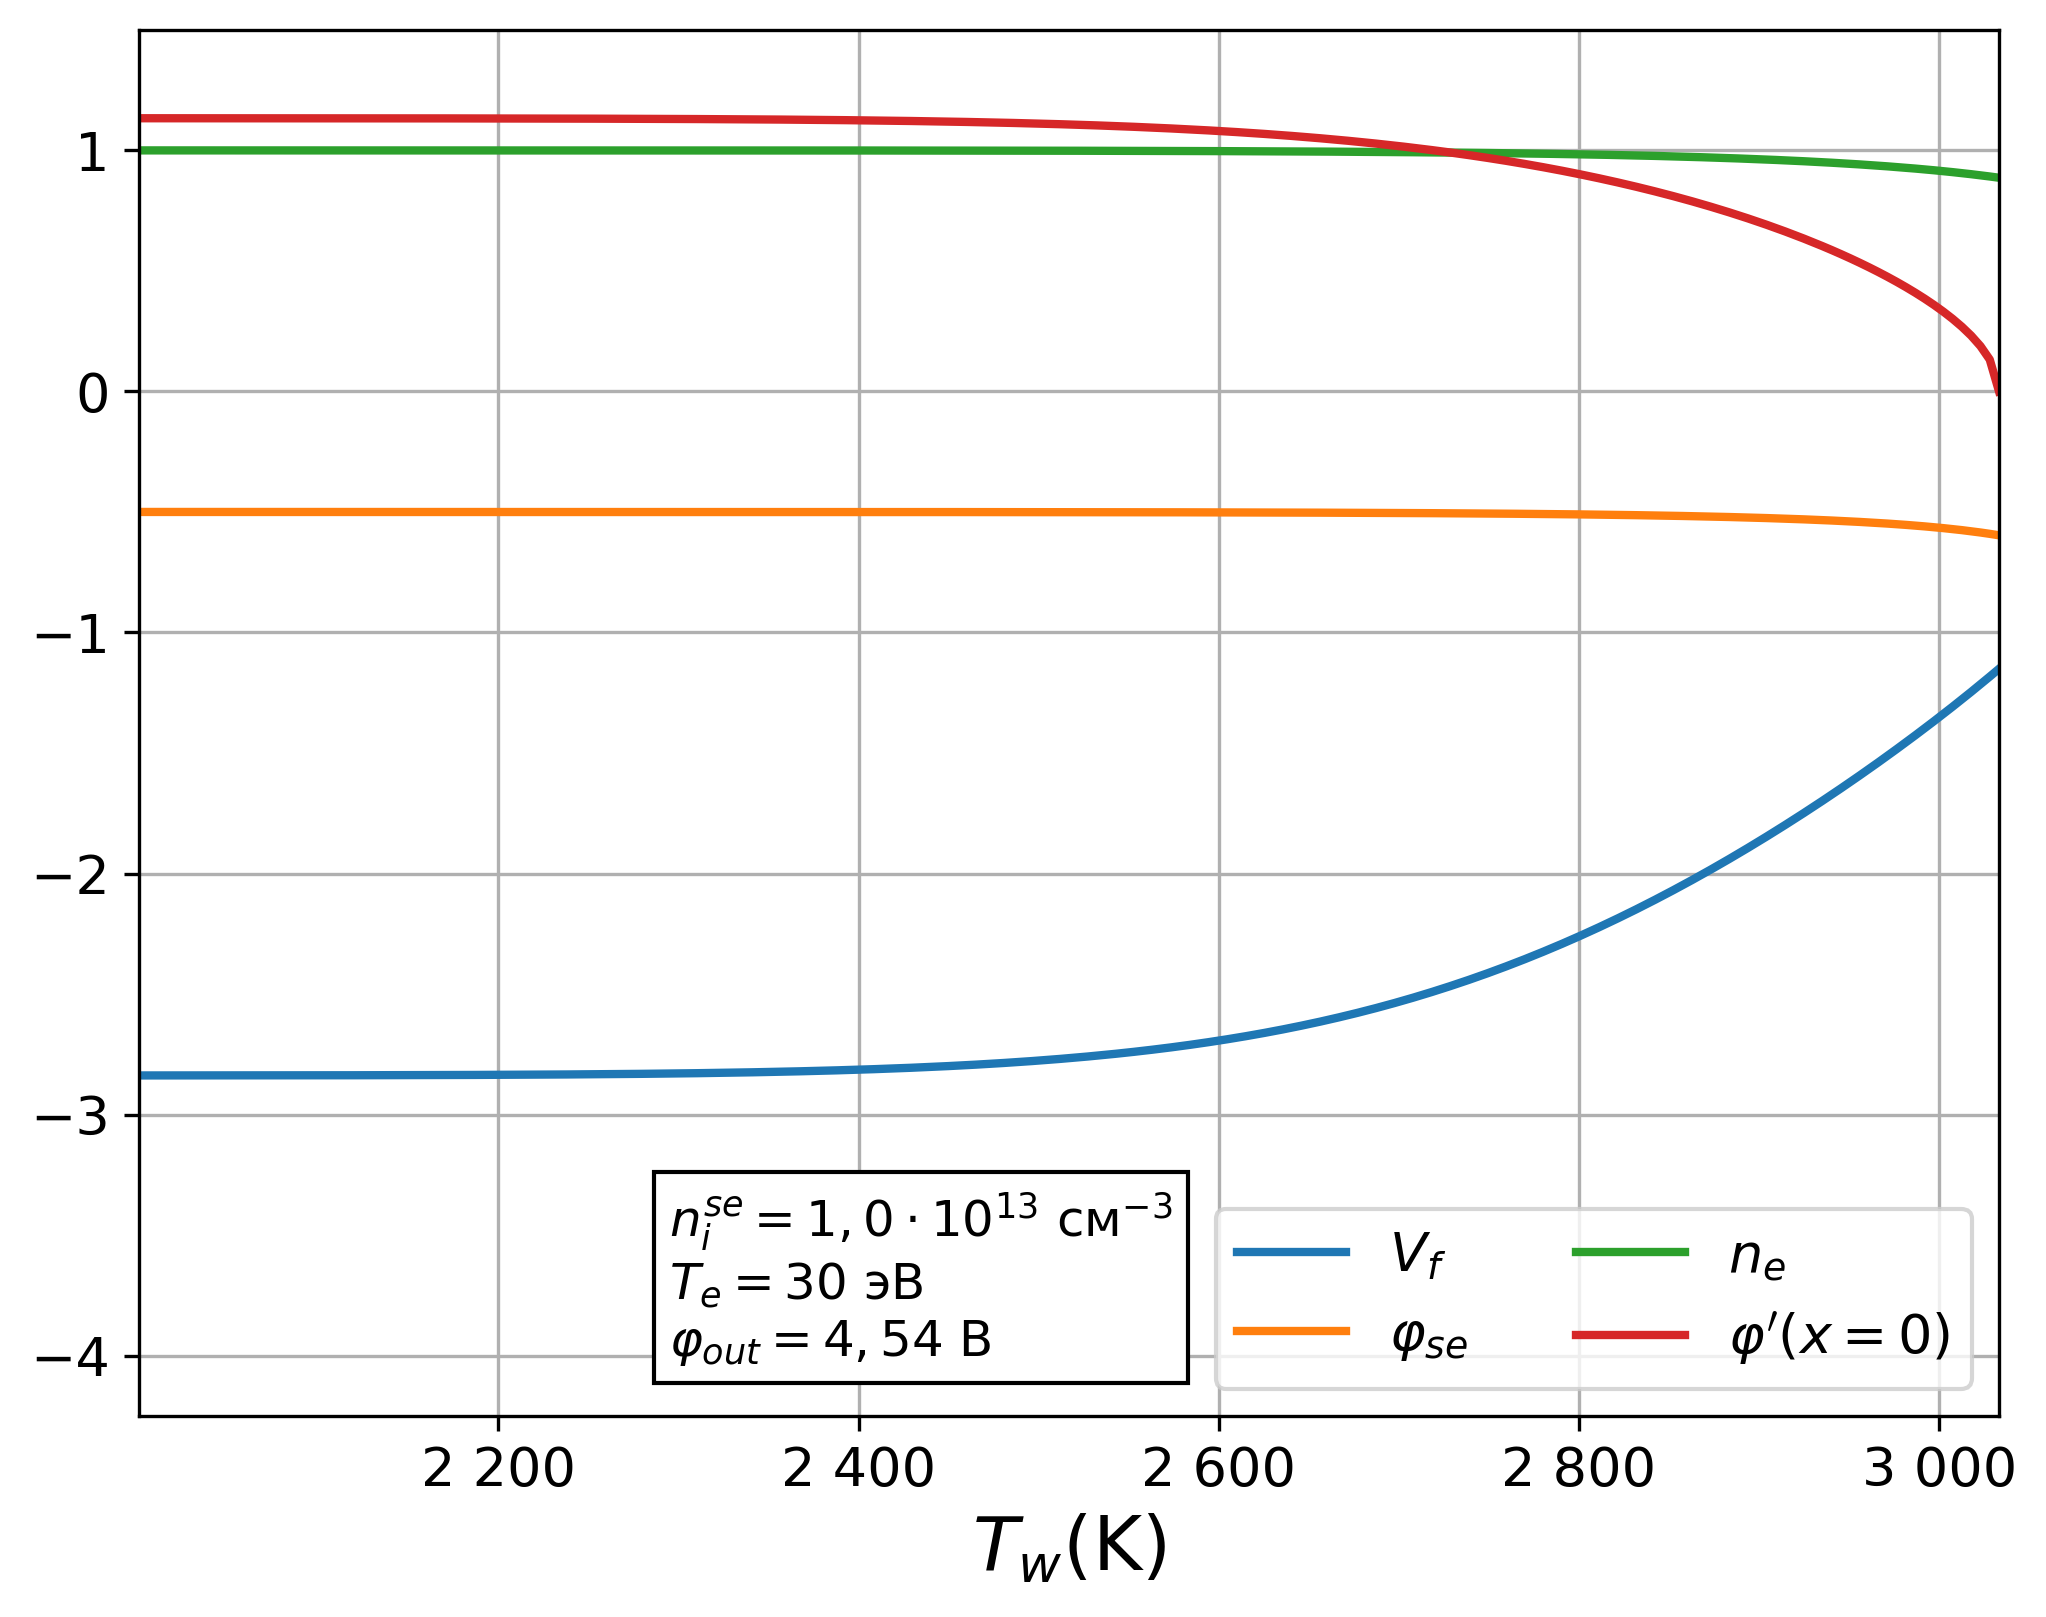

6.092180067712869e-11


In [5]:
Tw_classic_net_plot_min = Tw_classic_net_min * Te * erg_to_K
Tw_classic_net_plot_max = Tw_classic_net_max * Te * erg_to_K
Tw_classic_net_plot = np.linspace(
    Tw_classic_net_plot_min, Tw_classic_net_plot_max, Tw_classic_net_steps
)

fig = plt.figure(figsize=(8, 6), dpi=300)
plt.grid()
plt.xlabel(r"$T_w$(K)", fontsize=18)
plt.xlim(Tw_classic_net_min * Te * erg_to_K, Tw_classic_net_max * Te * erg_to_K)
plt.plot(Tw_classic_net_plot, V_f_classic_net, lw=2, label=r"$V_f$")
plt.plot(Tw_classic_net_plot, phi_se_classic_net, lw=2, label=r"$\varphi_{se}$")
plt.plot(Tw_classic_net_plot, n_e_classic_net, lw=2, label=r"$n_e$")
plt.plot(Tw_classic_net_plot, derw_classic_net, lw=2, label=r"$\varphi'(x = 0)$")
plt.legend(loc="lower right", ncols=2)
plt.text(
    Tw_classic_net_plot[int(Tw_classic_net_steps / 3.5)],
    -4.0,
    r"$n_i^{se} = "  # %1.f
    r"%1.0f"
    r",%1.0f"
    r"\cdot10^{%d}$ см$^{-3}$"
    "\n"
    r"$T_e = %0.f$ эВ"
	"\n"
	r"$\varphi_{out} = 4"
	','
	r"54$ В"
	#r"$\varphi_{out} = %1.0f,%2.0f$ В"
    % (
        (nse / 10 ** floor(log10(nse))) % 10,
        (nse / 10 ** floor(log10(nse))) / 10,
        floor(log10(nse)),
        Te * erg_to_eV
		# (erg_to_eV * phiout / 10 ** floor(log10(erg_to_eV * phiout))) % 10,
		# (erg_to_eV * phiout / 10 ** floor(log10(erg_to_eV * phiout))) / 10
    ),
    fontsize=12,
    bbox=props,
)
plt.ylim(-4.25, 1.5)
plt.show()
print(derw_classic_net[-1])

In [6]:
def pois_eq(x, y, args):
    derw, V_f, phi_se, n_e, Tw, nte_w, upsilon_0 = args
    return [
        y[1],
        -(
            1 / np.sqrt(1 - 2 * (y[0] - phi_se) / upsilon_0**2)
            - n_e * np.exp(y[0] - phi_se)
            - nte_w
            * np.exp((y[0] - (V_f + phi_se)) / Tw)
            * special.erfc(np.sqrt((y[0] - (V_f + phi_se)) / Tw))
        ),
    ]


def pois_bc(ya, yb, args):
    derw, V_f, phi_se, n_e, Tw, nte_w, upsilon_0 = args
    return np.array([yb[1], ya[0] - (phi_se + V_f)])


def sys_poisson(y, args):
    derw, V_f, phi_se, n_e = y
    Tw, nse, xmax = args
    pois_args = [
        derw,
        V_f,
        phi_se,
        n_e,
        Tw,
        nte_w_func(derw, Tw),
        upsilon_0_func(phi_se),
    ]
    pois_x = np.linspace(0, xmax, 501)
    pois_y = np.zeros((2, pois_x.size))
    pois_y[0, :] = 1.0 * phi_se
    sol = solve_bvp(
        lambda pois_x, pois_y: pois_eq(pois_x, pois_y, pois_args),
        lambda pois_x, pois_y: pois_bc(pois_x, pois_y, pois_args),
        pois_x,
        pois_y,
    )
    return sol


def ne_func(n_e_se, phi, phi_se):
    return n_e_se * np.exp(phi - phi_se)


def ni_func(phi, phi_se):
    upsilon_0 = np.sqrt(-2 * phi_se)
    return 1 / np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)


def nte_func(derw, phi, phi_se, V_f, Tw):
    return (
        nte_w_func(derw, Tw)
        * np.exp((phi - (V_f + phi_se)) / Tw)
        * special.erfc(np.sqrt((phi - (V_f + phi_se)) / Tw))
    )

0.008713703950585176


C:\Users\popac\AppData\Local\Temp\ipykernel_8780\1305933669.py:10: RuntimeWarning: invalid value encountered in sqrt
  * special.erfc(np.sqrt((y[0] - (V_f + phi_se)) / Tw))


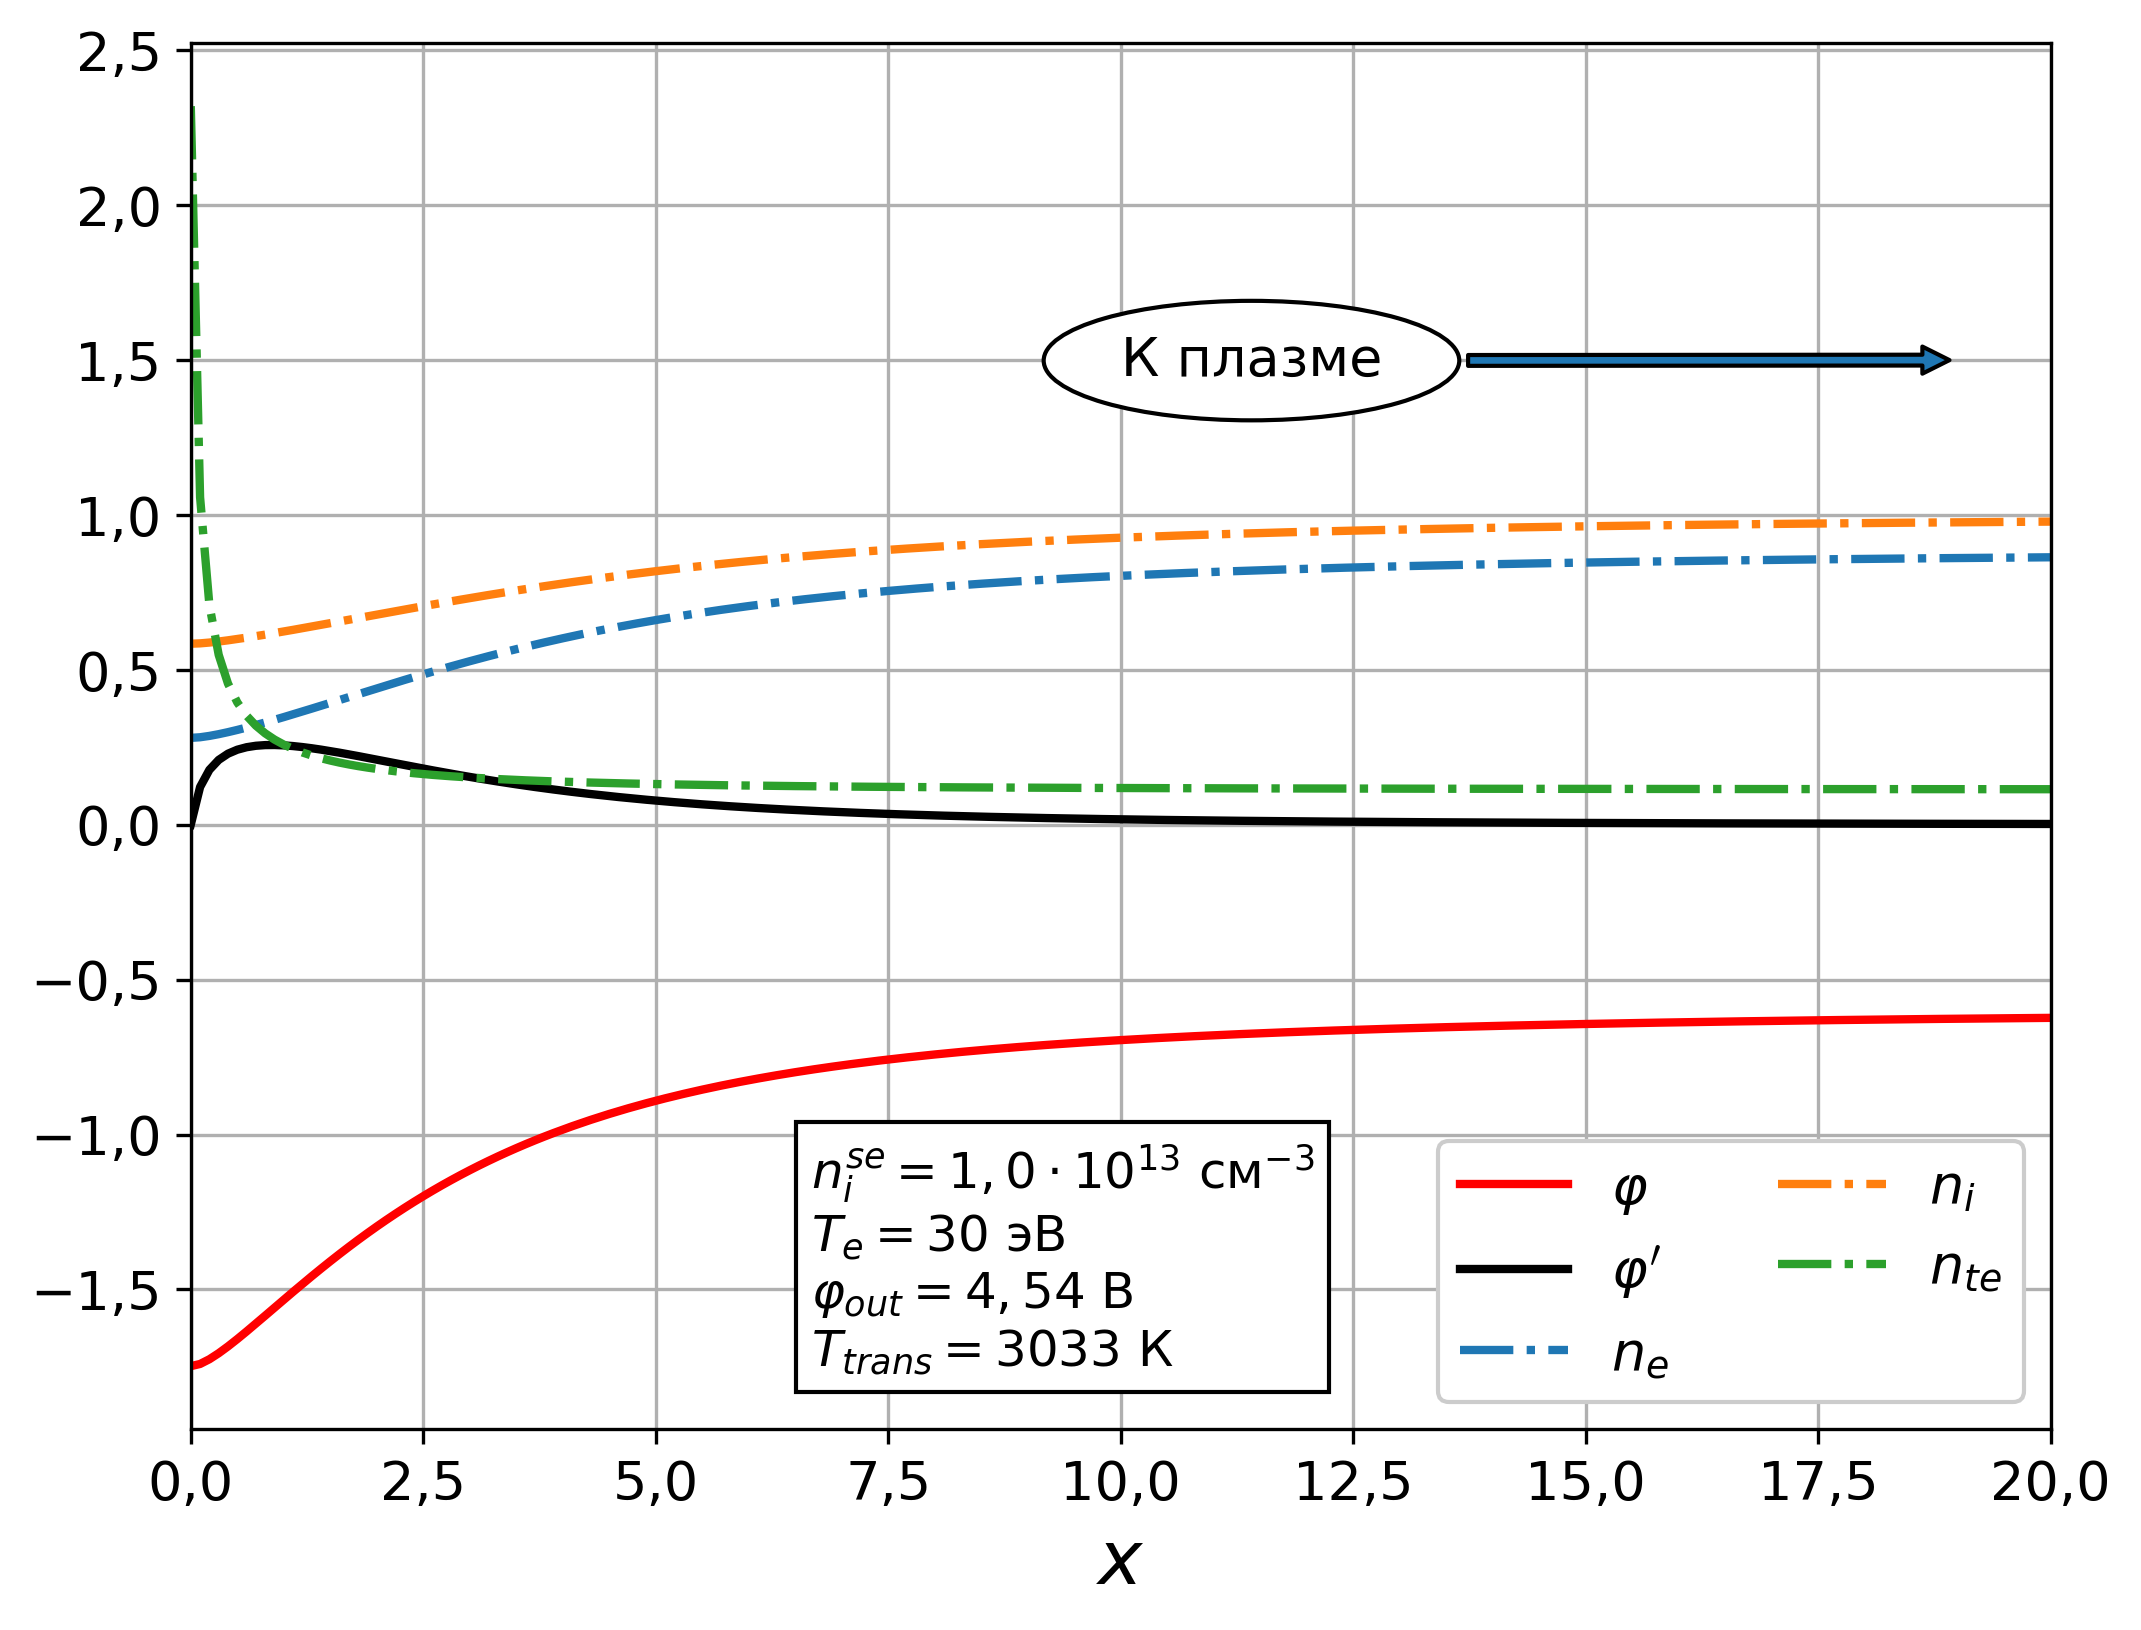

3.6986642932986418
7.5555887237380315
0.1135368232407618


In [7]:
fig = plt.figure(figsize=(8, 6), dpi=300)

# point = -1
# print("Tw : ", Tw_classic_net_plot[point])
# print("n_e : ", n_e_classic_net[point])
# print("phi_se : ", phi_se_classic_net[point])
# print("V_f : ", V_f_classic_net[point])


def params_set(point):
    if point >= 0 and point < Tw_classic_net_steps:
        return [
            derw_classic_net[point],
            n_e_classic_net[point],
            Tw_classic_net[point],
            phi_se_classic_net[point],
            V_f_classic_net[point],
        ]
    else:
        return [
            derw_classic_net[point],
            n_e_classic_net[Tw_classic_net_steps - 1],
            Tw_classic_net[Tw_classic_net_steps - 1],
            phi_se_classic_net[Tw_classic_net_steps - 1],
            V_f_classic_net[Tw_classic_net_steps - 1],
        ]


derw, n_e_se, Tw, phi_se, V_f = params_set(-1)
print(Tw)

# ne_se = 0.981
# Tw = TD(2961)
# phi_se = -0.096
# V_f = -2.46

xmax = 100

sol = sys_poisson([derw, V_f, phi_se, n_e_se], [Tw, nse, xmax])
x_plot = np.linspace(0, xmax, 1001)
y_plot = sol.sol(x_plot)[0]
plt.plot(x_plot, y_plot, color="r", lw=2, label=r"$\varphi$")
y1_plot = sol.sol(x_plot)[1]
plt.plot(x_plot, y1_plot, color="k", lw=2, label=r"$\varphi'$")

ne_net = ne_func(n_e_se, y_plot, phi_se)
plt.plot(
    x_plot, ne_func(n_e_se, y_plot, phi_se), lw=2, label=r"$n_e$", linestyle="dashdot"
)

ni_net = ni_func(y_plot, phi_se)
plt.plot(x_plot, ni_net, lw=2, label=r"$n_i$", linestyle="dashdot")

nte_net = nte_func(derw, y_plot, phi_se, V_f, Tw)
plt.plot(x_plot, nte_net, lw=2, label=r"$n_{te}$", linestyle="dashdot")

x_net_plot_lim = 20
plt.xlim(0.0, x_net_plot_lim)
plt.text(
    x_net_plot_lim / 3,
    y_plot[0],
    r"$n_i^{se} = "  # %1.f
    r"%1.0f"
    r",%1.0f"
    r"\cdot10^{%d}$ см$^{-3}$"
    "\n"
    r"$T_e = %0.f$ эВ"
	"\n"
	r"$\varphi_{out} = 4"
	','
	r"54$ В"
    "\n"
    r"$T_{trans} = %0.f$ К"
    % (
        (nse / 10 ** floor(log10(nse))) % 10,
        (nse / 10 ** floor(log10(nse))) / 10,
        floor(log10(nse)),
        Te * erg_to_eV,
        TK(Tw_trans),
    ),
    fontsize=12,
    bbox=props,
)

arrowprops = {"arrowstyle": "simple"}
plt.annotate(
    r"К плазме",
    xy=(x_net_plot_lim - 1, 1.5),
    xytext=(x_net_plot_lim / 2, 1.45),
    arrowprops=arrowprops,
    bbox=props_note,
)

plt.legend(loc="lower right", ncols=2, framealpha=1)
plt.xlabel(r"$x$", fontsize=18)
plt.grid()
plt.show()
print(0.25*nte_net[0]*np.sqrt(8*Tw*mi/(np.pi*me)))
print(nte_net[-1]*(0.25*np.sqrt(8*Tw*mi/(np.pi*me)) + np.sqrt(-2*V_f_trans/(me/mi))))
print(nte_net[-1])

# SCL

In [8]:
def jwall_scl(y, args):
    derw, n_e_se, V_vc, phi_se, V_f = y
    Tw, nte_w, upsilon_0 = args
    return (
        upsilon_0
        - 0.25 * n_e_se * np.sqrt(8 * mi / (np.pi * me)) * np.exp(V_vc)
        + 0.25 * nte_w * np.sqrt(Tw * 8 * mi / (np.pi * me)) * np.exp((V_vc - V_f) / Tw)
    )  #


def quasineutrality_scl(y, args):
    derw, n_e_se, V_vc, phi_se, V_f = y
    Tw, nte_w, upsilon_0 = args
    return (
        1 - n_e_se - nte_w * special.erfc(np.sqrt((-V_vc) / Tw)) * np.exp(-V_f / Tw)
    )  #


def Bohm_scl(y, args):
    derw, n_e_se, V_vc, phi_se, V_f = y
    Tw, nte_w, upsilon_0 = args
    return (
        -1.0 / upsilon_0**2
        + n_e_se
        + nte_w
        / Tw
        * np.exp(-V_f / Tw)
        * (
            special.erfc(np.sqrt(-V_vc / Tw))
            - np.exp(V_vc / Tw) / np.sqrt(np.pi * (-V_vc) / Tw)
        )
    )  # ~~~


def Poisson_integrated_scl_beta(phi, y, args):
    derw, n_e_se, V_vc, phi_se, V_f = y
    Tw, nte_w, upsilon_0 = args
    return (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e_se * np.exp(phi - phi_se)
        + nte_w
        * Tw
        * np.exp(-(V_f + phi_se) / Tw)
        * (
            np.exp(phi / Tw) * special.erfc(np.sqrt((phi - (V_vc + phi_se)) / Tw))
            + 2.0
            / np.sqrt(np.pi)
            * np.exp((V_vc + phi_se) / Tw)
            * np.sqrt((phi - (V_vc + phi_se)) / Tw)
        )
    )  # ~~~


def Poisson_scl_beta(y, args):
    derw, n_e_se, V_vc, phi_se, V_f = y
    return -2 * (
        Poisson_integrated_scl_beta(V_vc + phi_se, y, args)
        - Poisson_integrated_scl_beta(phi_se, y, args)
    )


def Poisson_integrated_scl_alpha(phi, y, args):
    derw, n_e_se, V_vc, phi_se, V_f = y
    Tw, nte_w, upsilon_0 = args
    addition = 0.000
    return (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e_se
        * np.exp(-phi_se)
        * (
            np.exp(phi) * special.erfc(np.sqrt(phi - (V_vc + phi_se) + addition))
            + 2.0
            / np.sqrt(np.pi)
            * np.sqrt(phi - (V_vc + phi_se) + addition)
            * np.exp(V_vc + phi_se)
        )
        + nte_w
        * Tw
        * np.exp((-(V_f + phi_se)) / Tw)
        * (
            np.exp(phi/Tw) * (1 + special.erf(np.sqrt((phi - (V_vc + phi_se))/Tw)))
            - 2.0
            / np.sqrt(np.pi)
            * np.sqrt((phi - (V_vc + phi_se))/Tw)
            * np.exp((V_vc + phi_se)/Tw)
        )
    )

def Poisson_scl_alpha(y, args):
    derw, n_e_se, V_vc, phi_se, V_f = y
    return derw**2 - 2 * (
        Poisson_integrated_scl_alpha(V_f + phi_se, y, args)
        - Poisson_integrated_scl_alpha(V_vc + phi_se, y, args)
    )
    # return V_vc - V_f


def sys_scl(y, args):
    Tw = args
    derw, n_e_se, V_vc, phi_se, V_f = y
    nte_w = nte_w_func(derw, Tw)
    # nte_w = nte_w_func(0, Tw)
    upsilon_0 = upsilon_0_func(phi_se)
    args1 = [Tw, nte_w, upsilon_0]
    return [
        quasineutrality_scl(y, args1),
        jwall_scl(y, args1),
        Bohm_scl(y, args1),
        Poisson_scl_alpha(y, args1),
        Poisson_scl_beta(y, args1),
    ]

In [9]:
Tw_SCL_net_max = TD(3695)
Tw_SCL_net_min = Tw_trans
Tw_SCL_net_steps = 201
Tw_SCL_net = np.linspace(Tw_SCL_net_min, Tw_SCL_net_max, Tw_SCL_net_steps)
#Tw_SCL_net = Tw_classic_net

V_f_SCL_net = [0] * Tw_SCL_net_steps
phi_se_SCL_net = [0] * Tw_SCL_net_steps
V_vc_SCL_net = [0] * Tw_SCL_net_steps
n_e_SCL_net = [0] * Tw_SCL_net_steps
derw_SCL_net = [0] * Tw_SCL_net_steps
print(TK(Tw_SCL_net_min))
for i in range(Tw_SCL_net_steps):
    Tw = Tw_SCL_net[i]
    args = (Tw,)
    if i == 0:
        sol = optimize.fsolve(
            sys_scl,
            [
                derw_classic_net[-1],
                n_e_classic_net[-1],
                V_f_classic_net[-1],
                phi_se_classic_net[-1],
                V_f_classic_net[-1],
            ],
            args=args,
        )
        print(sol)
    else:
        sol = optimize.fsolve(
            sys_scl,
            [
                derw_SCL_net[i-1],
                n_e_SCL_net[i-1],
                V_vc_SCL_net[i-1],
                phi_se_SCL_net[i-1],
                V_f_SCL_net[i-1]+0.0005,
            ],
            args=args,
        )
    derw_SCL_net[i] = sol[0]
    n_e_SCL_net[i] = sol[1]
    V_vc_SCL_net[i] = sol[2]
    phi_se_SCL_net[i] = sol[3]
    V_f_SCL_net[i] = sol[4]
    if (
        np.isclose(sys_scl(sol, *args), [0.0, 0.0, 0.0, 0.0, 0.0])[0] == False
        or np.isclose(sys_scl(sol, *args), [0.0, 0.0, 0.0, 0.0, 0.0])[1] == False
        or np.isclose(sys_scl(sol, *args), [0.0, 0.0, 0.0, 0.0, 0.0])[2] == False
        or np.isclose(sys_scl(sol, *args), [0.0, 0.0, 0.0, 0.0, 0.0])[3] == False
        or np.isclose(sys_scl(sol, *args), [0.0, 0.0, 0.0, 0.0, 0.0])[4] == False
    ) :
        print(f"{TK(Tw):.1f}", " : ", sys_scl(sol, *args))
    # else:
    # 	print(f'{TK(Tw):.1f}', " : ", "OK")

3033.22797173909
[ 6.09218007e-11  8.86539031e-01 -1.15072268e+00 -5.96939660e-01
 -1.15072268e+00]
3039.9  :  [np.float64(-8.202556689429485e-11), np.float64(2.6636599592677612e-09), np.float64(-3.566522771558667e-11), np.float64(1.898742152026643e-08), np.float64(3.496900546906545e-10)]
3043.2  :  [np.float64(-1.265337848388448e-09), np.float64(4.106654927227282e-08), np.float64(-5.506495537321854e-10), np.float64(-6.052979857544376e-07), np.float64(5.371659561603792e-09)]
3046.5  :  [np.float64(-5.650571677229266e-10), np.float64(1.833113127958086e-08), np.float64(-2.456610401213588e-10), np.float64(-1.5030491651735894e-07), np.float64(2.389154651893932e-09)]
3049.8  :  [np.float64(-5.19200599180536e-10), np.float64(1.6854845963365506e-08), np.float64(-2.26145886739193e-10), np.float64(-3.865468964879548e-08), np.float64(2.201981708083167e-09)]
3053.1  :  [np.float64(-4.992392055314099e-10), np.float64(1.620625100784423e-08), np.float64(-2.1717033726886825e-10), np.float64(-1.053537

C:\Users\popac\AppData\Local\Temp\ipykernel_8780\21986728.py:71: RuntimeWarning: invalid value encountered in sqrt
  np.exp(phi) * special.erfc(np.sqrt(phi - (V_vc + phi_se) + addition))
C:\Users\popac\AppData\Local\Temp\ipykernel_8780\21986728.py:74: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(phi - (V_vc + phi_se) + addition)
C:\Users\popac\AppData\Local\Temp\ipykernel_8780\21986728.py:81: RuntimeWarning: invalid value encountered in sqrt
  np.exp(phi/Tw) * (1 + special.erf(np.sqrt((phi - (V_vc + phi_se))/Tw)))
C:\Users\popac\AppData\Local\Temp\ipykernel_8780\21986728.py:84: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt((phi - (V_vc + phi_se))/Tw)
C:\Users\popac\AppData\Local\Temp\ipykernel_8780\3957198734.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = optimize.fsolve(


Варьирование системы по (V_f, V_vc)

In [10]:
# # debug
# dticks = 101

# fig = plt.figure(figsize=(8, 6), dpi=300)
# # derw_3d_net = np.linspace(-1.0, derw_classic_net[-1], dticks)
# # n_e_3d_net = np.linspace(0.7, n_e_classic_net[-1], dticks)
# # V_f_3d_net = np.linspace(-3.0, 0.0, dticks)
# # phi_se_3d_net = np.linspace(-0.8, phi_se_classic_net[-1], dticks)
# # V_vc_3d_net = np.linspace(-3.0, 0.0, dticks)

# # derw_3d_net = derw_classic_net
# # n_e_3d_net = n_e_classic_net
# # V_f_3d_net = np.linspace(-3.0, 0.0, dticks)
# # phi_se_3d_net = phi_se_classic_net
# # V_vc_3d_net = np.linspace(-3.0, 0.0, dticks)

# derw_3d_net = derw_SCL_net
# n_e_3d_net = n_e_SCL_net
# V_f_3d_net = np.linspace(-3.0, 0.0, dticks)
# phi_se_3d_net = phi_se_SCL_net
# V_vc_3d_net = np.linspace(-3.0, 0.0, dticks)

# quasineutrality_classic_values = np.zeros((dticks, dticks))
# quasineutrality_values = np.zeros((dticks, dticks))
# j_wall_values = np.zeros((dticks, dticks))
# poisson_beta_values = np.zeros((dticks, dticks))
# Bohm_values = np.zeros((dticks, dticks))
# poisson_alpha_values = np.zeros((dticks, dticks))

# n = -1
# for i in range(dticks):
# 	for j in range(dticks):
# 		# args = Tw_classic_net[n]
# 		args = Tw_SCL_net[n]
# 		y = [derw_3d_net[n], n_e_3d_net[n], V_vc_3d_net[j], phi_se_3d_net[n], V_f_3d_net[i]]
# 		quasineutrality_classic_values[i][j] = sys([derw_3d_net[n], n_e_3d_net[n], V_f_3d_net[i], phi_se_3d_net[n]], args, nse)[0]
# 		quasineutrality_values[i][j] = sys_scl(y, args)[0]
# 		j_wall_values[i][j] = sys_scl(y, args)[1]
# 		Bohm_values[i][j] = sys_scl(y, args)[2]
# 		poisson_alpha_values[i][j] = sys_scl(y, args)[3]
# 		poisson_beta_values[i][j] = sys_scl(y, args)[4]

# V_f_3d_net, V_vc_3d_net = np.meshgrid(V_f_3d_net, V_vc_3d_net, indexing = 'ij')
# plw = 2

# pcl = plt.contour(V_f_3d_net, V_vc_3d_net, quasineutrality_classic_values, levels = [0.0], linewidths = [plw], colors= ['grey'], linestyles = 'dashed')
# p0 = plt.contour(V_f_3d_net, V_vc_3d_net, quasineutrality_values, levels = [0.0], linewidths = [plw], colors= ['g'])
# p1 = plt.contour(V_f_3d_net, V_vc_3d_net, j_wall_values, levels = [0.0], linewidths = [plw], colors= ['r'])
# p2 = plt.contour(V_f_3d_net, V_vc_3d_net, Bohm_values, levels = [0.0], linewidths = [plw], colors= ['cyan'])
# p3 = plt.contour(V_f_3d_net, V_vc_3d_net, poisson_alpha_values, levels = [0.0], linewidths = [plw], colors= ['orange'])
# p4 = plt.contour(V_f_3d_net, V_vc_3d_net, poisson_beta_values, levels = [0.0], linewidths = [plw], colors= ['b'])
# plt.xlabel(r"$V_f$")
# plt.grid()
# plt.ylabel(r"$V_{vc}$")
# plt.show()

Компиляция решения в режимах Classic, SCL

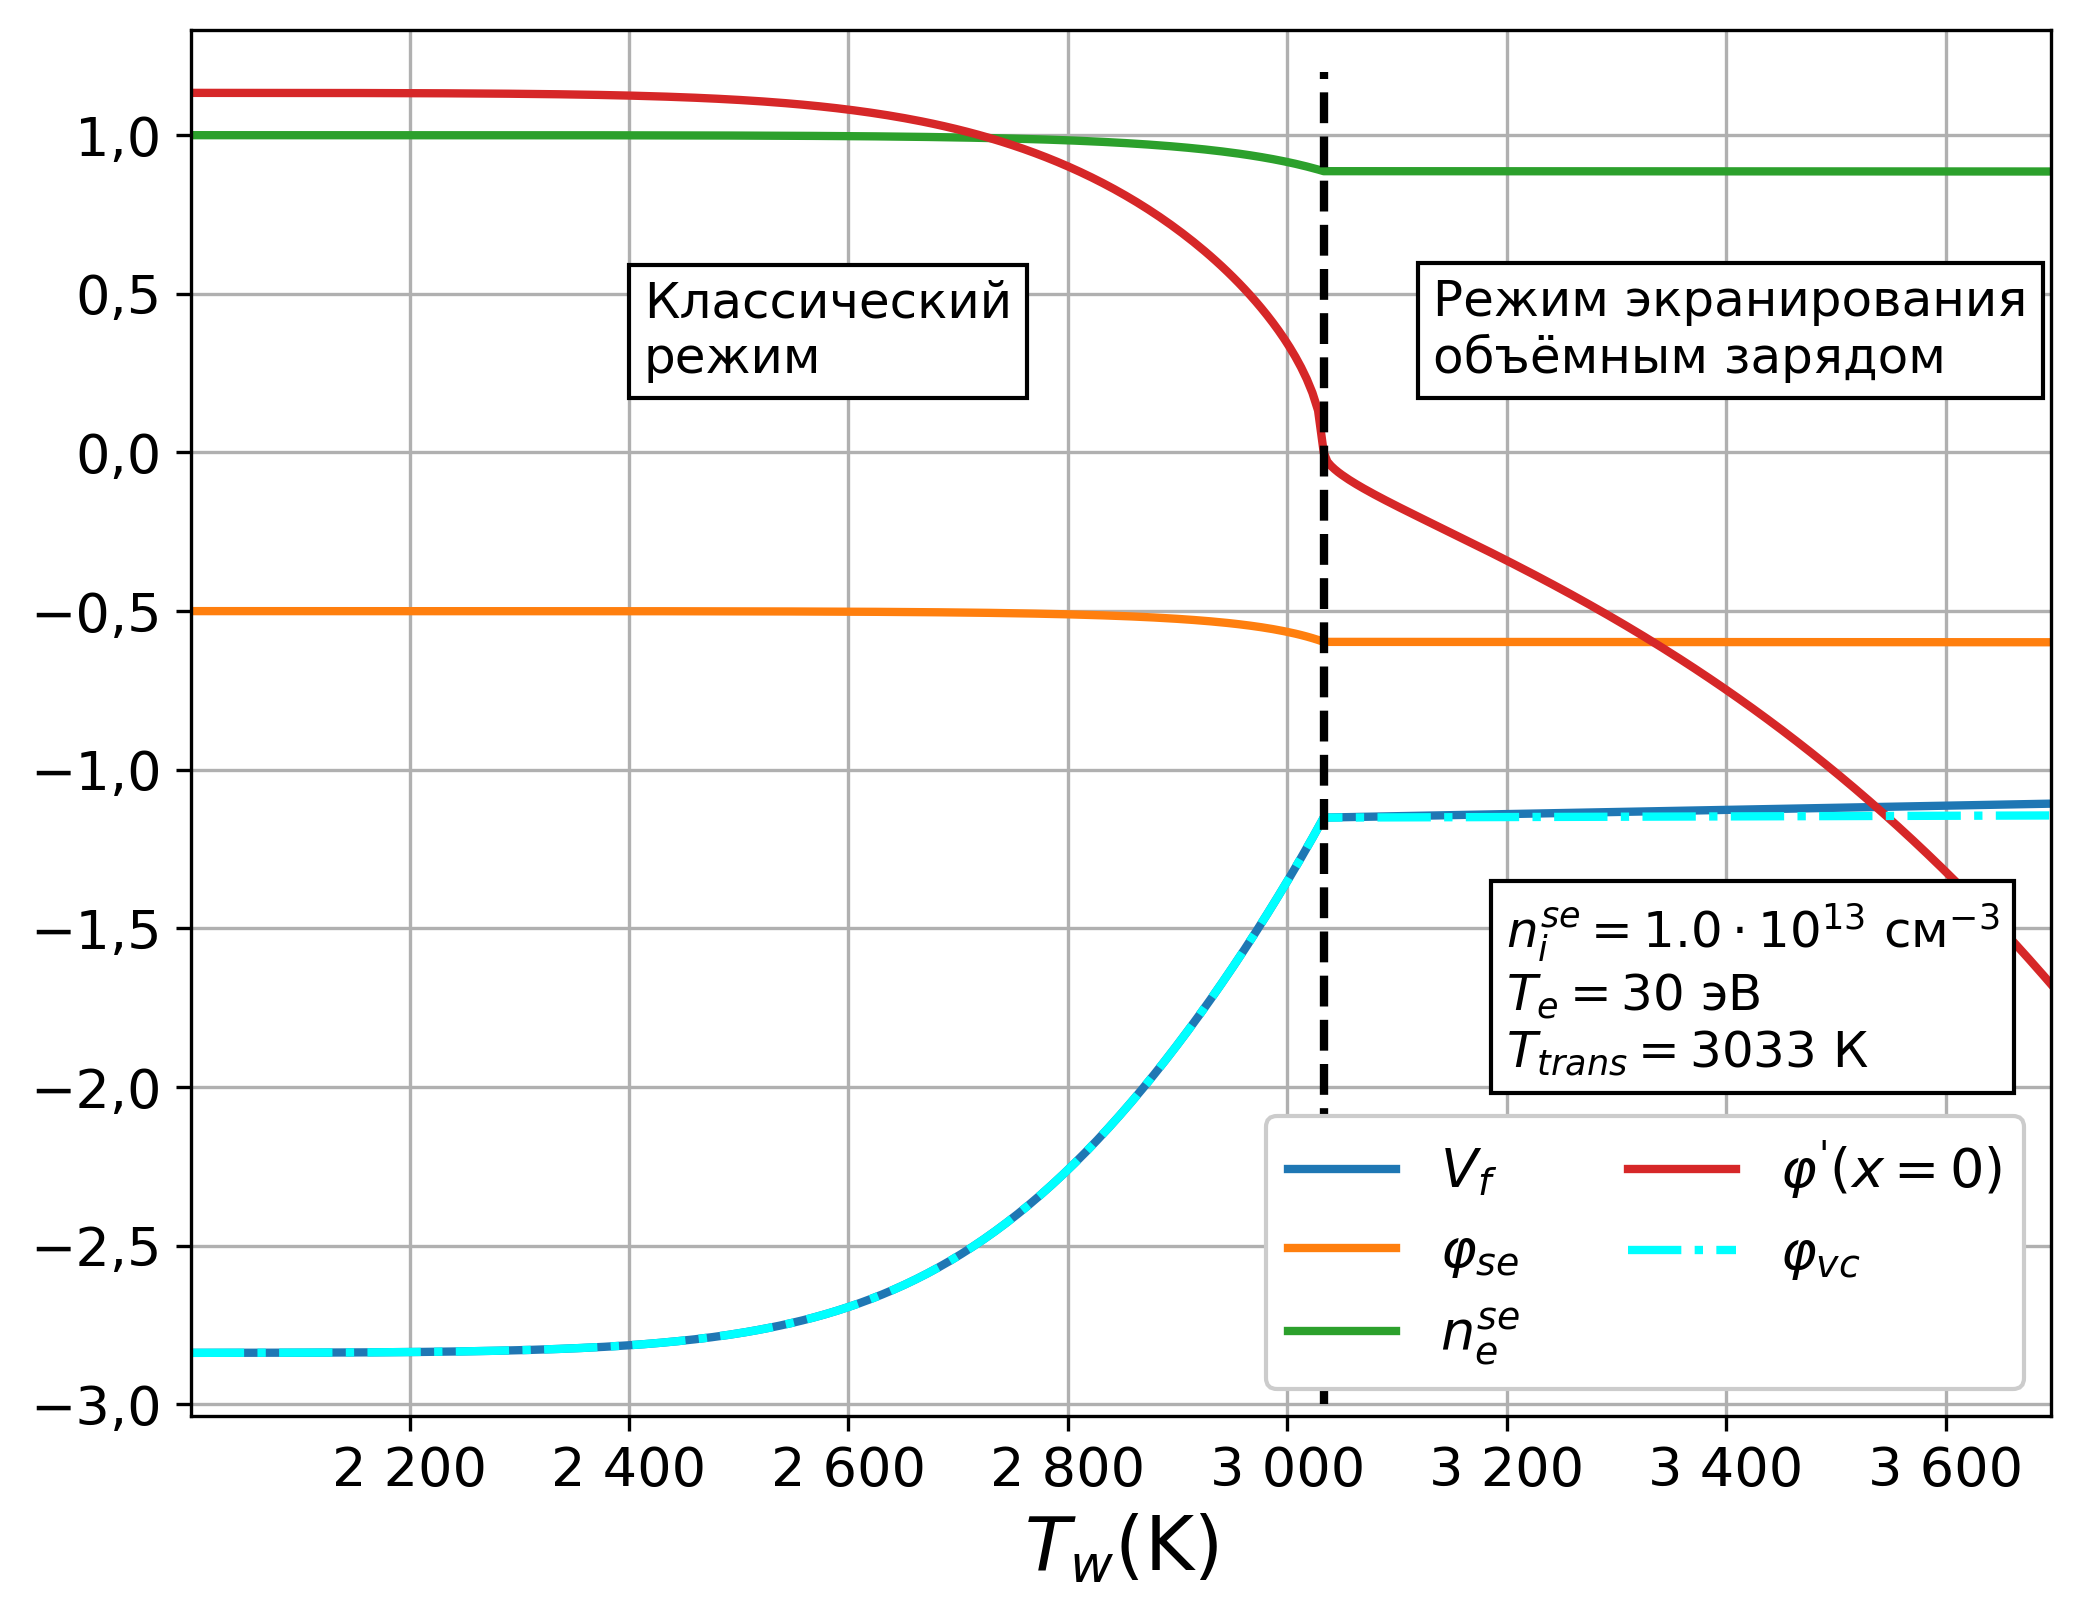

-1.1507226768669567
0.006688855103516911 -0.00581274292890371
-0.0010203669269085447 -0.00115095544778266
23.04552857151188


In [11]:
Tw_SCL_net_plot_min = Tw_SCL_net_min * Te * erg_to_K
Tw_SCL_net_plot_max = Tw_SCL_net_max * Te * erg_to_K
Tw_SCL_net_plot = np.linspace(
    Tw_SCL_net_plot_min, Tw_SCL_net_plot_max, Tw_SCL_net_steps
)

fig = plt.figure(figsize=(8, 6), dpi=300)

Tw_all_net_plot = np.concatenate((Tw_classic_net_plot, Tw_SCL_net_plot[1:]))
Tw_all_net = np.concatenate((Tw_classic_net, Tw_SCL_net[1:]))
V_f_all_net = V_f_classic_net + V_f_SCL_net[1:]
V_vc_all_net = V_f_classic_net + V_vc_SCL_net[1:]
derw_all_net = derw_classic_net + derw_SCL_net[1:]

n_e_all_net = np.concatenate((n_e_classic_net, n_e_SCL_net[1:]))
phi_se_all_net = np.concatenate((phi_se_classic_net, phi_se_SCL_net[1:]))

plt.plot(Tw_all_net_plot, V_f_all_net, lw=2, label=r"$V_f$")
plt.plot(Tw_all_net_plot, phi_se_all_net, lw=2, label=r"$\varphi_{se}$")
plt.plot(Tw_all_net_plot, n_e_all_net, lw=2, label=r"$n_e^{se}$")
plt.plot(Tw_all_net_plot, derw_all_net, lw=2, label=r"$\varphi^'(x = 0)$")
plt.plot(Tw_all_net_plot, V_vc_all_net, lw=2, label=r"$\varphi_{vc}$", color = 'cyan', linestyle = '-.')

plt.text(
    Tw_all_net_plot[int(len(Tw_all_net_plot) / 1.6)],
    V_f_all_net[0] + 0.9,
    r"$n_i^{se} = %.1f\cdot10^{%d}$ см$^{-3}$"
    "\n"
    r"$T_e = %0.f$ эВ"
    "\n"
    r"$T_{trans} = %0.f$ К"
    % (nse / 10 ** floor(log10(nse)), floor(log10(nse)), Te * erg_to_eV, TK(Tw_trans)),
    fontsize=12,
    bbox=props,
)

plt.text(
    Tw_all_net_plot[int(len(Tw_all_net_plot)/5)],
    (n_e_all_net[0] + phi_se_all_net[0])/2,
    r"Классический"
    "\n"
    r"режим",
    fontsize=12,
    bbox=props,
)

plt.text(
    TK(Tw_trans) + 100,
    (n_e_all_net[0] + phi_se_all_net[0])/2,
    r"Режим экранирования"
    "\n"
    r"объёмным зарядом",
    fontsize=12,
    bbox=props,
)

# arrowprops = {"arrowstyle": "->"}
# plt.annotate(
#     r"Переход между режимами",
#     xy=(TK(Tw_trans), phi_vc_net_all[0] + 1.0),
#     xytext=(Tw_net_all_plot[int(len(Tw_net_all_plot) / 1.4)], phi_vc_net_all[0] + 1.0),
#     arrowprops=arrowprops,
#     bbox = props
# )

# plt.arrow(3700, 0.5, -100, 0.7, arrowprops = arrowprops)
# plt.ylim(-3, 1)
plt.xlim(Tw_classic_net_plot_min, Tw_SCL_net_plot_max)
plt.plot((TK(Tw_trans), TK(Tw_trans)), (-3.0, 1.2), lw = 2, color = 'k', scaley=False, linestyle = 'dashed')
plt.legend(loc = 'lower right', ncols=2, framealpha = 1)
plt.grid()
plt.xlabel(r"$T_w$(K)", fontdict = dict(fontsize = 18))
plt.show()
print(V_f_classic_net[-1])

print(V_vc_all_net[-1] - V_f_trans, (V_vc_all_net[-1] - V_f_trans)/V_f_trans)
print(n_e_all_net[-1] - n_e_trans, (n_e_all_net[-1] - n_e_trans)/n_e_trans)
print((V_f_all_net[-1] - V_f_trans)/(Tw_all_net[-1] - Tw_trans))

In [12]:
def q_func(y, Tw_net, Tw_trans):
    derw_net, V_f_net, phi_se_net, n_e_net, V_vc_net = y
    q_net = []
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        if (Tw_net[i] <= Tw_trans):
            q_net.append((
                upsilon_0 * (upsilon_0**2 / 2 - V_f_net[i])
                + 0.25 * n_e_net[i] * vth * 2 * np.exp(V_f_net[i])
                - 0.25 * nte_w_func(derw_net[i], Tw_net[i]) * vteth * 2 * Tw_net[i]
                - sigma * (Tw_net[i]*Te)**4 / (nse * cs * Te)
            )
            )
        else:
            q_net.append((
                upsilon_0 * (upsilon_0**2 / 2 - V_f_net[i])
                + 0.25 * n_e_net[i] * vth * 2 * np.exp(V_f_net[i])
                - 0.25 * nte_w_func(derw_net[i], Tw_net[i]) * vteth * 2 * Tw_net[i] * special.erfc(np.sqrt((V_f_net[i] - V_vc_net[i])/Tw))
                - sigma * (Tw_net[i]*Te)**4 / (nse * cs * Te)
            )
            )
    return q_net

# q_net = q_func([derw_classic_net, V_f_classic_net, phi_se_classic_net, n_e_classic_net], Tw_classic_net, Tw_trans)
q_net = q_func([derw_all_net, V_f_all_net, phi_se_all_net, n_e_all_net, V_vc_all_net], Tw_all_net, Tw_trans)

def q_ion_func(y, Tw_net, Tw_trans):
    derw_net, V_f_net, phi_se_net, n_e_net = y
    q_net = []
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        q_net.append(
            upsilon_0 * (upsilon_0**2 / 2)
		)
    return q_net

# q_ion_net = q_ion_func([derw_classic_net, V_f_classic_net, phi_se_classic_net, n_e_classic_net], Tw_classic_net, Tw_trans)
q_ion_net = q_ion_func([derw_all_net, V_f_all_net, phi_se_all_net, n_e_all_net], Tw_all_net, Tw_trans)

def q_e_func(y, Tw_net, Tw_trans):
    derw_net, V_f_net, phi_se_net, n_e_net = y
    q_net = []
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        if (Tw_net[i] <= Tw_trans):
            # q_net.append(
            #     0.25 * n_e_net[i] * vth * 2 * np.exp(V_f_net[i])
            # )
            q_net.append(
                0.25 * n_e_net[i] * vth * 2 * np.exp(V_f_net[i])
            )
        else:
            q_net.append(
                0.25 * n_e_net[i] * vth * 2 * np.exp(V_f_net[i])
            )
    return q_net

# q_e_net = q_e_func([derw_classic_net, V_f_classic_net, phi_se_classic_net, n_e_classic_net], Tw_classic_net, Tw_trans)
q_e_net = q_e_func([derw_all_net, V_f_all_net, phi_se_all_net, n_e_all_net], Tw_all_net, Tw_trans)

def q_te_func(y, Tw_net, Tw_trans):
    derw_net, V_f_net, phi_se_net, n_e_net, V_vc_net = y
    q_net = []
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        if (Tw_net[i] <= Tw_trans):
            # q_net.append(
            #     - 0.25 * nte_w_func(derw_net[i], Tw_net[i]) * vteth * 2 * Tw_net[i]
            # )
            q_net.append(
                - 0.25 * nte_w_func(derw_net[i], Tw_net[i]) * vteth * 2 * Tw_net[i]
            )
        else:
            q_net.append(
                - 0.25 * nte_w_func(derw_net[i], Tw_net[i]) * vteth * 2 * Tw_net[i] * special.erfc(np.sqrt((V_f_net[i] - V_vc_net[i])/Tw))
            )
    return q_net

#q_te_net = q_te_func([derw_classic_net, V_f_classic_net, phi_se_classic_net, n_e_classic_net], Tw_classic_net, Tw_trans)
q_te_net = q_te_func([derw_all_net, V_f_all_net, phi_se_all_net, n_e_all_net, V_vc_all_net], Tw_all_net, Tw_trans)

def q_bb_func(y, Tw_net, Tw_trans):
    derw_net, V_f_net, phi_se_net, n_e_net = y
    q_net = []
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        q_net.append(
            - sigma * (Tw_net[i]*Te)**4 / (nse * cs * Te)
		)
    return q_net

# q_bb_net = q_bb_func([derw_classic_net, V_f_classic_net, phi_se_classic_net, n_e_classic_net], Tw_classic_net, Tw_trans)
q_bb_net = q_bb_func([derw_all_net, V_f_all_net, phi_se_all_net, n_e_all_net], Tw_all_net, Tw_trans)

Text(0.5, -0.2, '$n_i^{se} = 1.0\\cdot10^{13}$ см$^{-3}$   $T_e = 30$ эВ   $T_{trans} = 3033$ К')

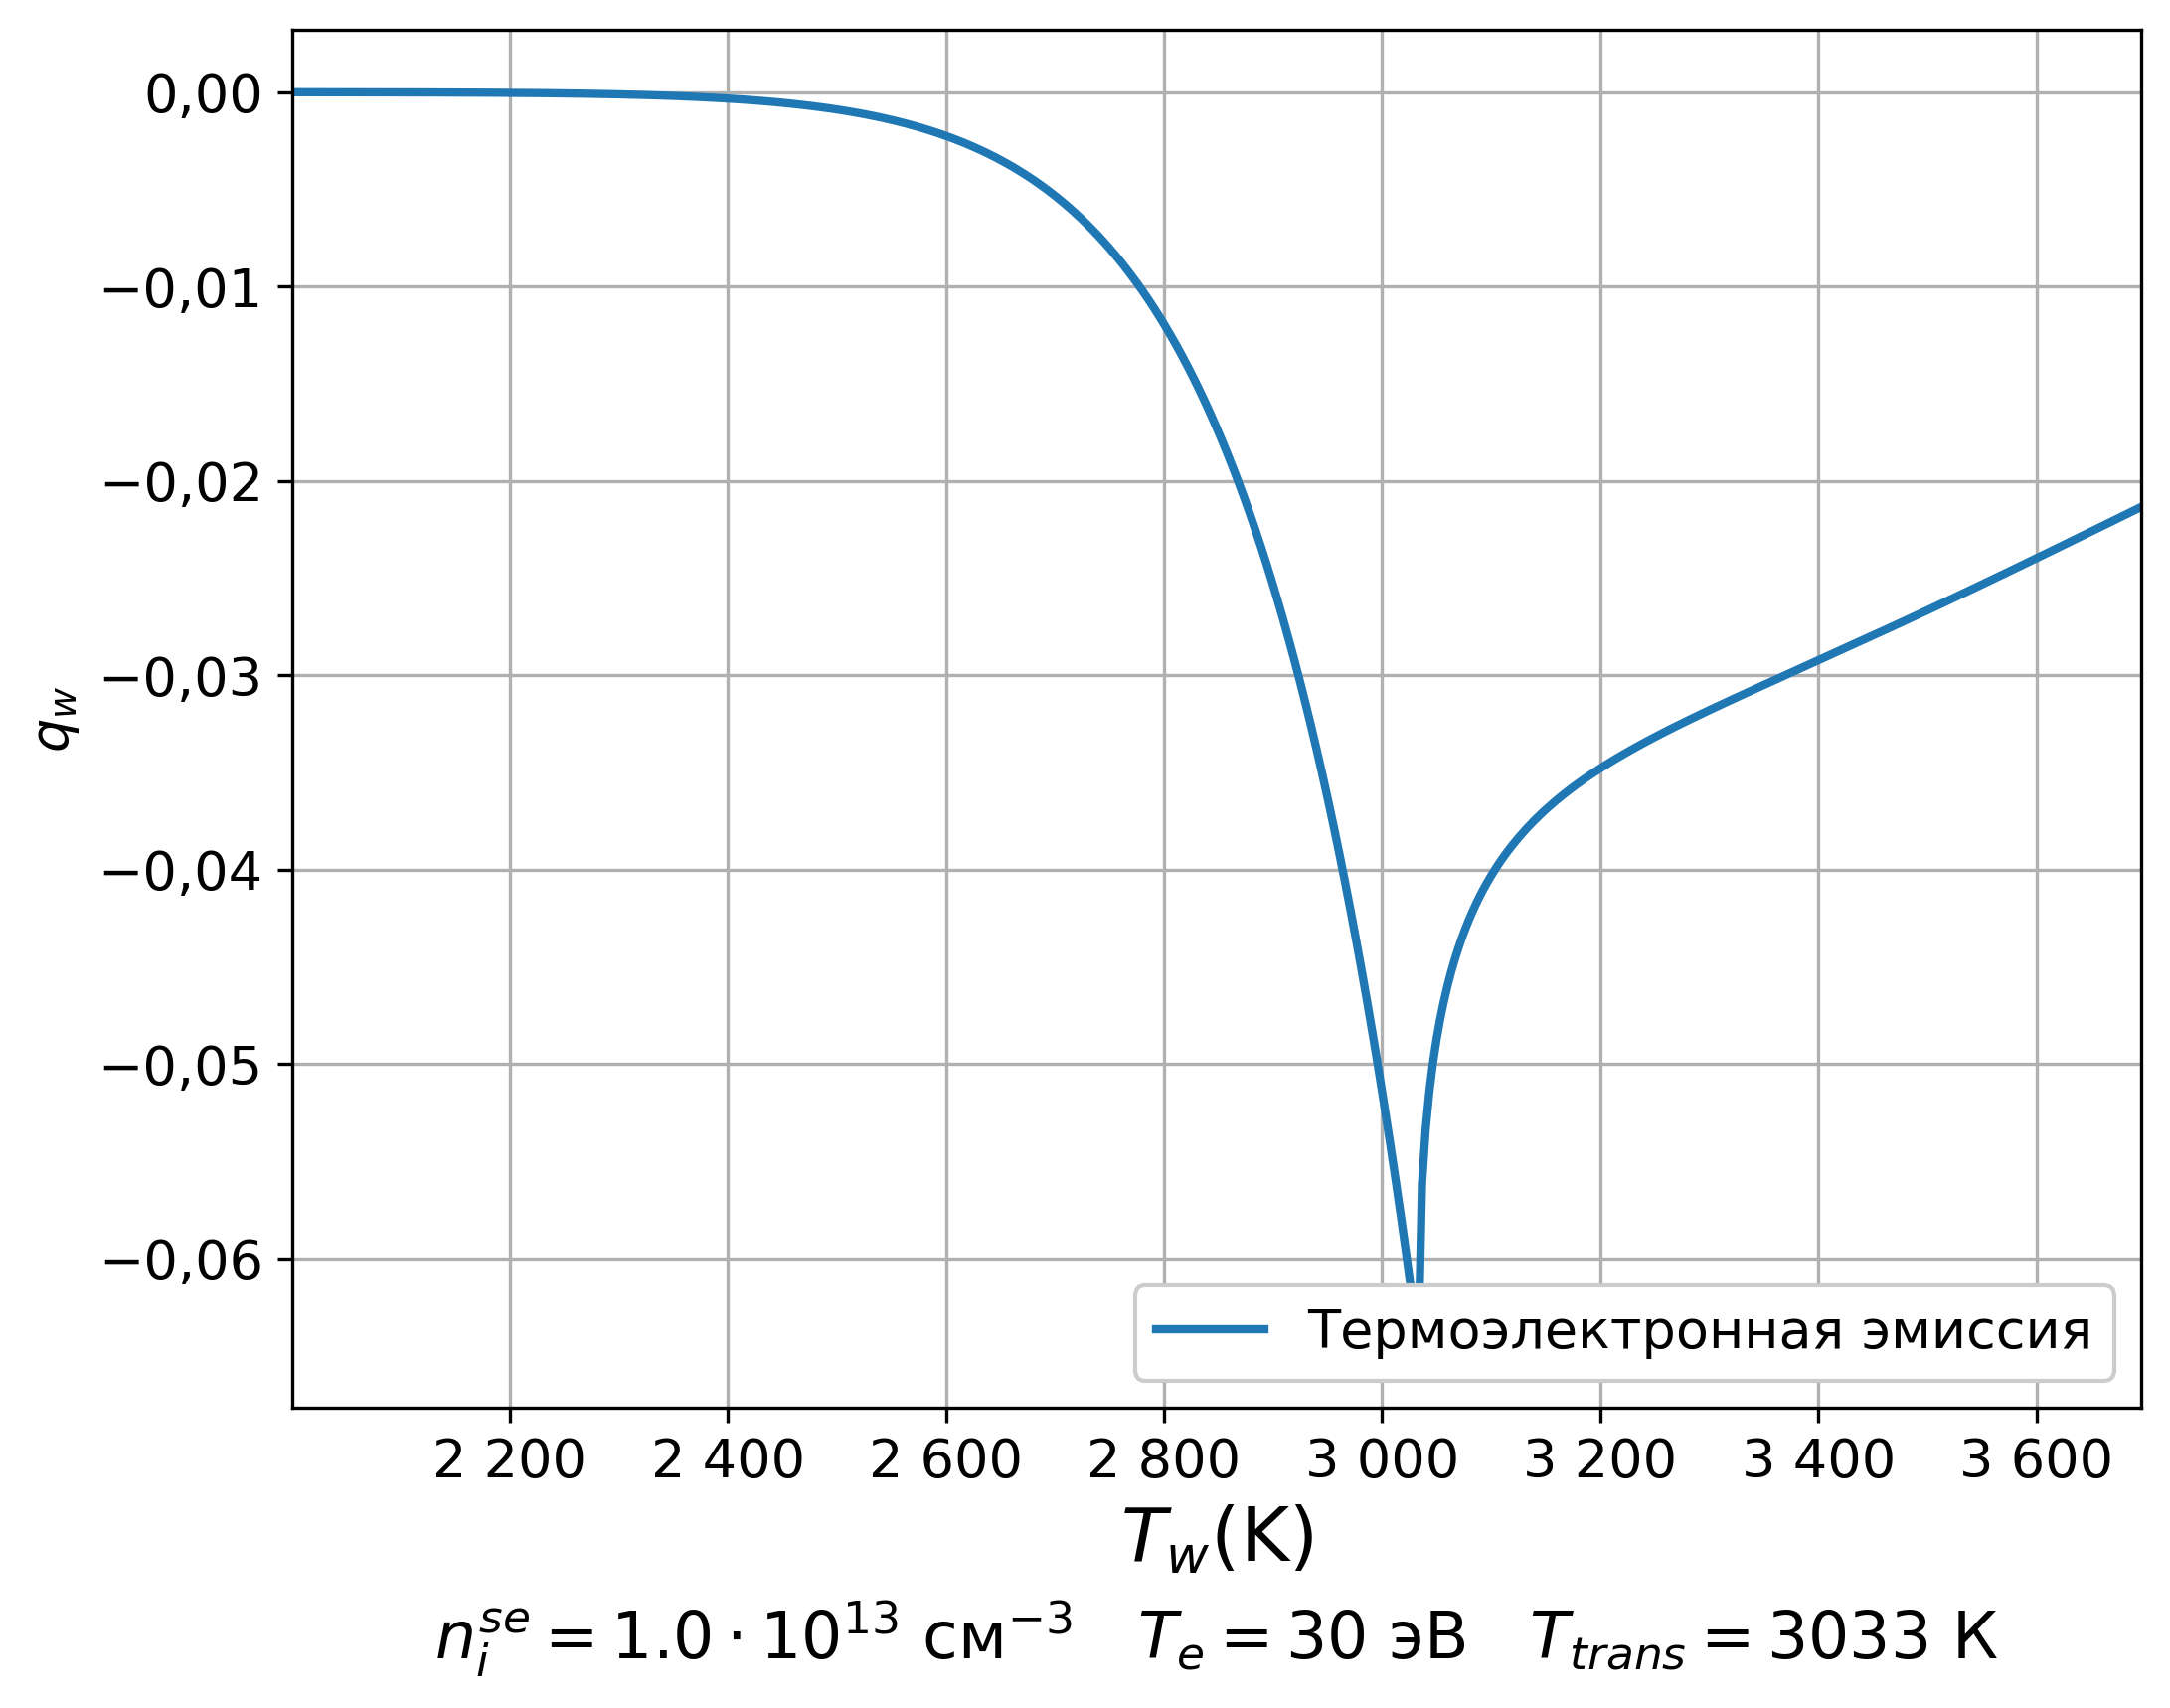

In [13]:
fig = plt.figure(figsize = (8, 6), dpi = 300)

# plt.plot(Tw_classic_net_plot, q_net, lw = 3, color = 'k', label = r"Суммарный")
# plt.plot(Tw_classic_net_plot, q_ion_net, lw = 2, label = r"Ионный")
# plt.plot(Tw_classic_net_plot, q_e_net, lw = 2, label = r"Электронный")
# plt.plot(Tw_classic_net_plot, q_te_net, lw = 2, label = r"Термоэлектронная эмиссия")
# plt.plot(Tw_classic_net_plot, q_bb_net, lw = 2, linestyle = "-.", label = r"Излучение абс.черного тела")

# plt.plot(Tw_all_net_plot, q_net, lw = 3, color = 'k', label = r"Суммарный")
# plt.plot(Tw_all_net_plot, q_ion_net, lw = 2, label = r"Ионный")
# plt.plot(Tw_all_net_plot, q_e_net, lw = 2, label = r"Электронный")
plt.plot(Tw_all_net_plot, q_te_net, lw = 2, label = r"Термоэлектронная эмиссия")
# plt.plot(Tw_all_net_plot, q_bb_net, lw = 2, linestyle = "-.", label = r"Излучение абс.черного тела")


# plt.text(
#     Tw_classic_net_plot[10],
#     max(q_net) * 1.1 - 3,
#     r"$n_i^{se} = "  # %1.f
#     r"%1.0f"
#     r",%1.0f"
#     r"\cdot10^{%d}$ см$^{-3}$"
#     "\n"
#     r"$T_e = %0.f$ эВ" 
# 	"\n"
# 	r"$T_{trans} = %0.f$ К" 
# 	"\n"
# 	r"$\varphi_{out} = 4,54$ В"
# 	    % ((nse / 10 ** floor(log10(nse))) % 10,
#         (nse / 10 ** floor(log10(nse))) / 10,
#         floor(log10(nse)), Te * erg_to_eV, TK(Tw_trans)),
#     fontsize=12,
#     bbox=props,
# )
#plt.plot((TK(Tw_trans), TK(Tw_trans)), (q_net[0], q_net[int(len(q_net)/1.2)]), lw = 2, color = 'k', scaley=False, linestyle = 'dashed')
plt.grid()
# plt.ylim(- 7.5, max(q_net) * 1.3)
plt.xlim(min(Tw_all_net_plot), max(Tw_all_net_plot))
# plt.plot((TK(Tw_trans), TK(Tw_trans)), (min(q_te_net) - 2, max(q_net) + 3), lw = 2, color = 'k', scaley=False, linestyle = 'dashed')
plt.legend(loc = 'lower right', ncols=2, framealpha = 1)
#plt.ylabel(r'$q_{w}$(МВт/м$^2$)', fontdict = dict(fontsize = 18))
plt.ylabel(r'$q_{w}$')
plt.xlabel(r"$T_w$(K)", fontdict = dict(fontsize = 18))
plt.title(r"$n_i^{se} = %.1f\cdot10^{%d}$ см$^{-3}$   "
    r"$T_e = %0.f$ эВ   "
    r"$T_{trans} = %0.f$ К"
    % (nse / 10 ** floor(log10(nse)), floor(log10(nse)), Te * erg_to_eV, TK(Tw_trans)),
	y = -0.2)

C:\Users\popac\AppData\Local\Temp\ipykernel_8780\3855625278.py:6: RuntimeWarning: invalid value encountered in scalar divide
  integral = quad(lambda tau: signal(omega, tau) / np.sqrt(t - tau), 0, t)
C:\Users\popac\AppData\Local\Temp\ipykernel_8780\3855625278.py:6: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  integral = quad(lambda tau: signal(omega, tau) / np.sqrt(t - tau), 0, t)
C:\Users\popac\AppData\Local\Temp\ipykernel_8780\3855625278.py:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = quad(lambda tau: signal(omega, tau) / np.sqrt(t - tau), 0, t)


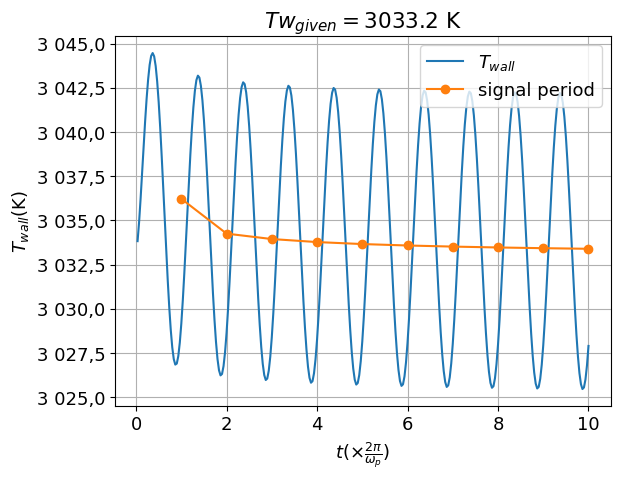

0.13436173466910217


In [14]:
def signal(omega, t):
    return np.sin(omega * t)


def T_func(T0, I_max, omega, t):
    integral = quad(lambda tau: signal(omega, tau) / np.sqrt(t - tau), 0, t)
    return (
        T0
        + I_max * nse * cs * Te
        / np.sqrt(np.pi * rho * Cp * kappa)
        * np.sqrt(2 * np.pi / np.sqrt(4 * np.pi * nse * e**2 / me))
        * integral[0]
    )

t_net_min = 0
t_net_max = 10
t_net_steps = 301
t_net = np.linspace(t_net_min, t_net_max, t_net_steps)

T_wall_net = [0]*t_net_steps
omega = 2*np.pi
T0 = 300

T_wall_net_median = []
t_net_median = []
Tw_step = Tw_classic_net_steps - 1
prev = 0
for i in range(t_net_steps):
    T_wall_net[i] = TK(T_func(Tw_classic_net[Tw_step], q_net[Tw_step], omega, t_net[i]))
    if (omega * t_net[i]/(2*np.pi) >= len(T_wall_net_median)):
        T_wall_net_median.append(median(T_wall_net[prev:i+1]))
        t_net_median.append(t_net[i])
        prev = i

plt.plot(t_net, T_wall_net, label = r'$T_{wall}$')
plt.plot(t_net_median, T_wall_net_median, label = r'signal period', marker = "o")
plt.title(r'$Tw_{given} = %0.1f$ K' %Tw_classic_net_plot[Tw_step])
plt.legend()
plt.xlabel(r'$t(\times \frac{2\pi}{\omega_p})$')
plt.ylabel(r'$T_{wall}$(K)')
plt.grid()
plt.show()
print(np.sqrt(kappa/Cp/rho*2*np.pi/(omega * np.sqrt(4*np.pi*nse*e**2/me)))/r_debye)